In [1]:
%matplotlib inline
import autograd.numpy as np
from autograd.numpy.linalg import inv, det
from autograd import grad
from functools import reduce
import autograd.numpy.random as npr
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, gamma, invgamma 
from scipy.special import digamma, polygamma
from scipy.special import gamma as gafun
from pykalman import KalmanFilter
from util2 import *
from kalman import *

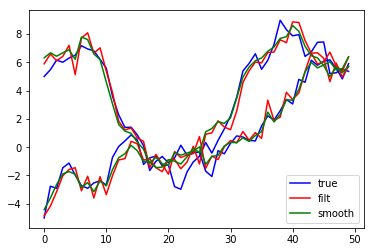

In [2]:
# specify parameters
random_state = np.random.RandomState(0)
transition_matrix = [[1, 0.1], [0, 1]]
transition_offset = [0, 0]
observation_matrix = np.eye(2)
observation_offset = [0, 0]
transition_covariance = np.eye(2)
observation_covariance = np.eye(2) 
initial_state_mean = [5, -5]
initial_state_covariance = [[1, 0.1], [-0.1, 1]]

# sample from model
kf = KalmanFilter(
    transition_matrix, observation_matrix, transition_covariance,
    observation_covariance, transition_offset, observation_offset,
    initial_state_mean, initial_state_covariance,
    random_state=random_state
)
states, observations = kf.sample(
    n_timesteps=50,
    initial_state=initial_state_mean
)

# estimate state with filtering and smoothing
filtered_state_estimates = kf.filter(observations)[0]
smoothed_state_estimates = kf.smooth(observations)[0]

# draw estimates
plt.figure()
lines_true = plt.plot(states, color='b')
lines_filt = plt.plot(filtered_state_estimates, color='r')
lines_smooth = plt.plot(smoothed_state_estimates, color='g')
plt.legend((lines_true[0], lines_filt[0], lines_smooth[0]),
          ('true', 'filt', 'smooth'),
          loc='lower right'
)
plt.show()


In [12]:
Q = kf.transition_covariance
A = np.array(kf.transition_matrices)
C = kf.observation_matrices
R = kf.observation_covariance
mu_x0 = np.array(initial_state_mean)
mu_x0.shape = (2, 1)
sigma_x0 = np.array(initial_state_covariance)
N = 2
K = 2
T = 50
video = np.array(observations).T
E_A = A
E_ATA = np.dot(A.T, A)
E_R_inv = inv(R)
E_C = C
E_R_inv_C = np.dot(E_R_inv, E_C)
E_CT_R_inv_C = np.dot(E_C.T, E_R_inv_C)
natstats_list = [E_A, E_ATA, E_R_inv, E_C, E_R_inv_C, E_CT_R_inv_C]
Mu_xt, Sigma_xt, Sigma_star, log_Z = forward(mu_x0, sigma_x0, N, T, K, video, *natstats_list)
psi_T_inv = np.zeros((K, K))
eta_T = np.ones((K, 1))
Psi, Eta = backward(psi_T_inv, eta_T, video, N, T, K, *natstats_list)
Gamma_ts, Omega_ts, Gamma_ttp1s = update_marginals(Mu_xt, Sigma_xt, Sigma_star, Psi, Eta, N, T, K, E_A, E_CT_R_inv_C)

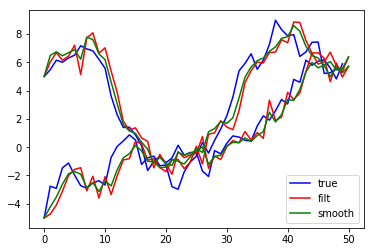

In [13]:
Mu_xt = np.squeeze(Mu_xt, -1)
Omega_ts = np.squeeze(Omega_ts, -1)
plt.figure()
lines_true = plt.plot(states, color='b')
lines_filt = plt.plot(Mu_xt, color='r')
lines_smooth = plt.plot(Omega_ts, color='g')
plt.legend((lines_true[0], lines_filt[0], lines_smooth[0]),
          ('true', 'filt', 'smooth'),
          loc='lower right'
)
plt.show()
